**Purpose**: Determine the Programming language with the most and least syntax noise.

**Author**: Alex

**Date**: 27 Jan 2022

**Data**: https://www.kaggle.com/simiotic/github-code-snippets-development-sample

**Cleaning Code**: https://github.com/alexlipson/code_snippets_short/blob/main/snippetAnalysis.py


In [2]:
#include all a..z, A..Z, 0..9, _

**Instructions:**
* Clean your data (handling missing data, correcting data types, recoding values, renaming columns, etc.).
* Examine the distribution of individual variables.
* Examine relationships between pairs of variables visually to determine any possible correlations.
* Identify outliers and decide whether or not those outliers should be included in your cleaned data.
* Develop a couple of statistical questions involving the distribution of one or more variables in your dataset.
* Record your thoughts and comments in markdown cells (be sure to include a prolog!).

In [16]:
library("tidyverse")
library("magrittr")
library("tibble")
library("data.table")
#install.packages("ggpubr")
#library("ggpubr")

options(repr.plot.width=10, repr.plot.height=6)


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




In [2]:
#codeSnippetsShort <- read_csv("data/snippetsSyntaxNoiseIgnoreLangs.csv")
codeSnippets <- read_csv("data/snippetsSyntaxNoise.csv")


── Column specification ────────────────────────────────────────────────────────
cols(
  noise_char_ratio = col_double(),
  language = col_character(),
  starting_line = col_double()
)




In [3]:
codeSnippets %<>%
    mutate(language = language %>% as.factor())

codeSnippets %>% summary()

#codeSnippets$language %>% summary()

 noise_char_ratio        language       starting_line   
 Min.   :0.00000   UNKNOWN   :1574797   Min.   :     0  
 1st Qu.:0.08759   C         : 617132   1st Qu.:    80  
 Median :0.12587   JavaScript: 448591   Median :   340  
 Mean   :0.13937   Go        : 405726   Mean   :  3380  
 3rd Qu.:0.17358   Java      : 375772   3rd Qu.:  1645  
 Max.   :0.99800   C++       : 327126   Max.   :999805  
                   (Other)   :1100856                   

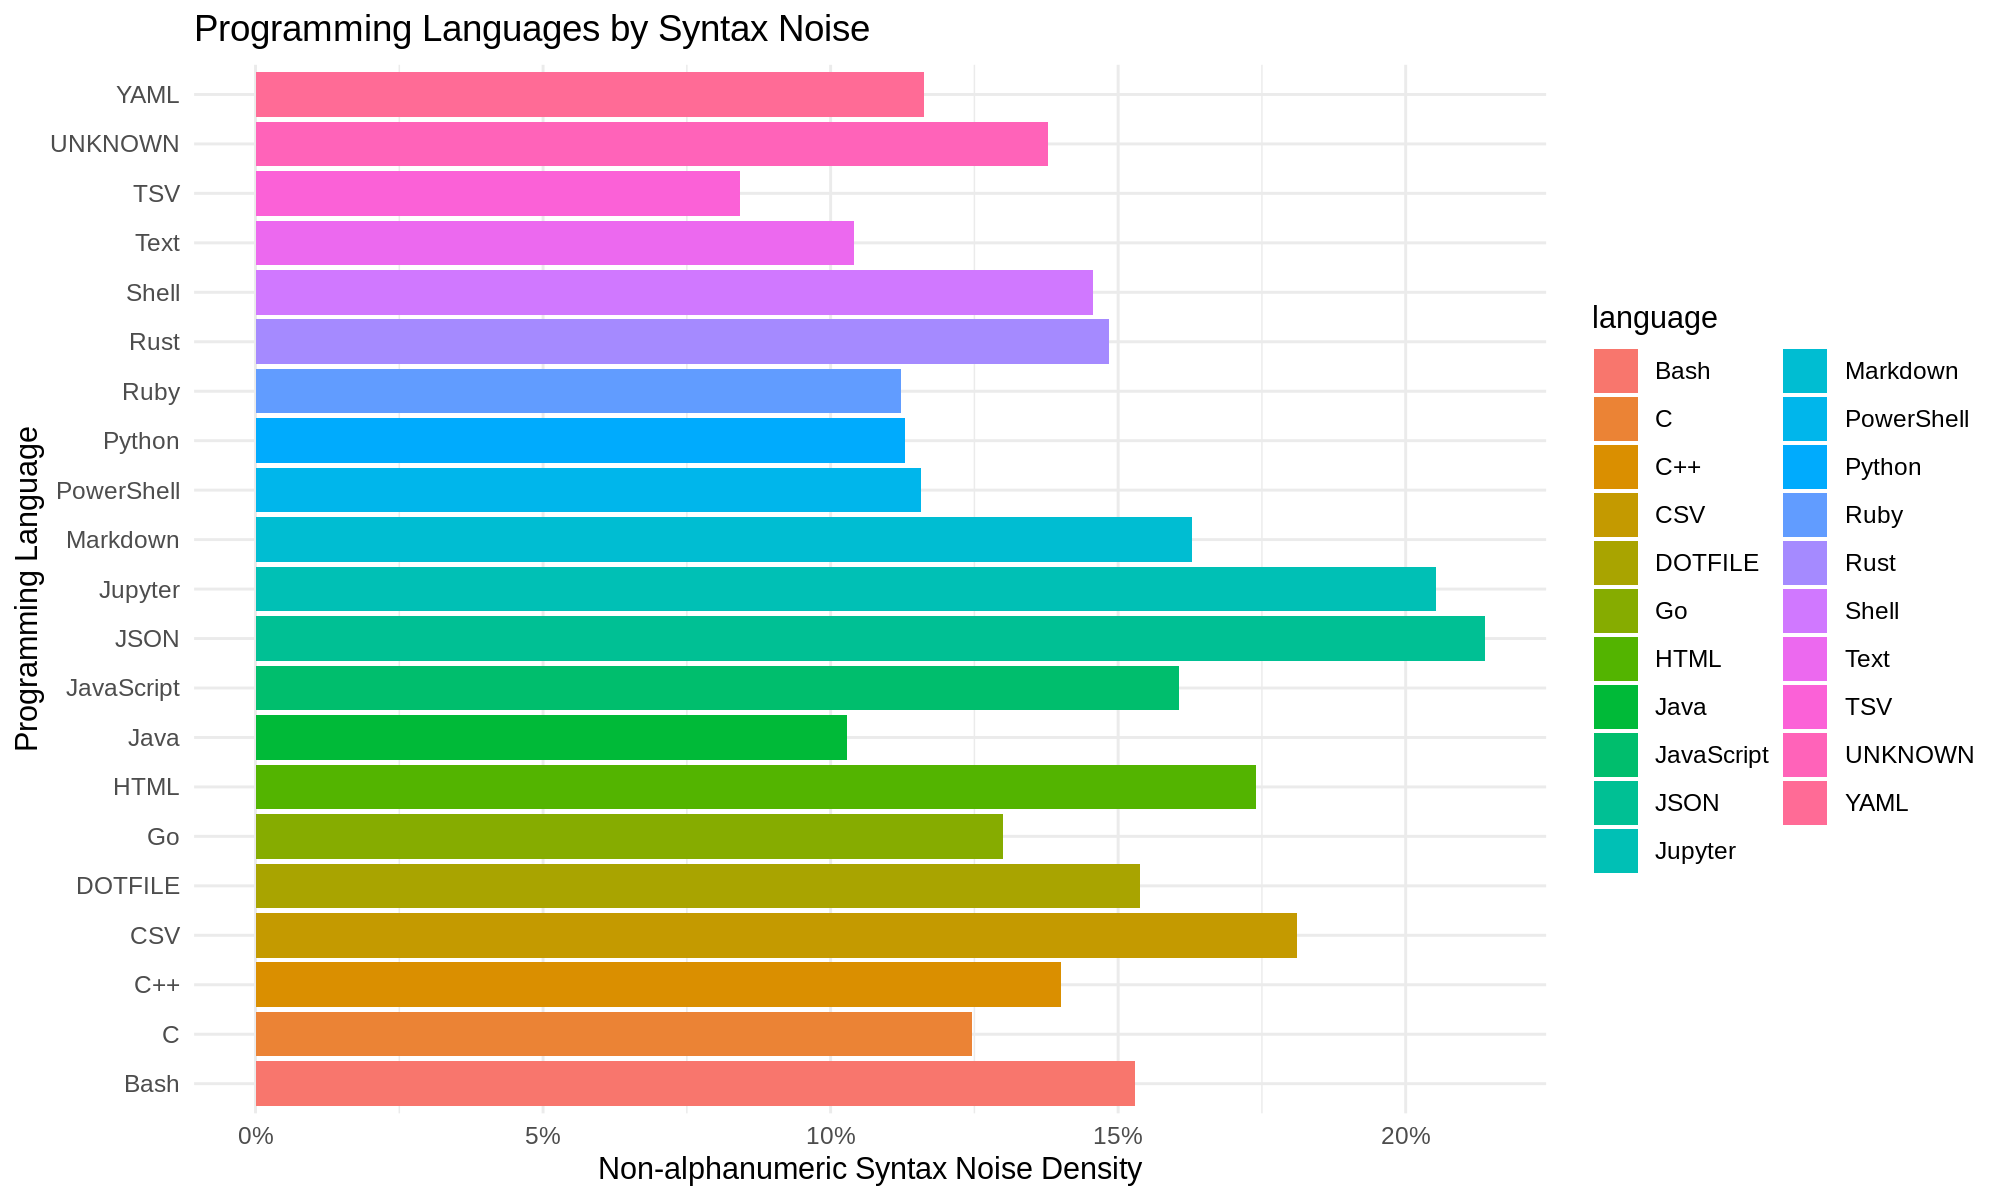

In [5]:
codeSnippets %>%
    group_by(language) %>%
    summarise_at(vars(noise_char_ratio), list(noise = mean)) %>% 
    mutate(language = language %>% fct_reorder(noise)) %>% 
    ggplot(aes(
        y = language,
        x = noise,
        fill = language
    )) +
    geom_col() +
    theme_minimal() +
    scale_x_continuous(
        breaks = c(0.00, 0.05, 0.10, 0.15, 0.20, 0.25),
        labels = c("0%", "5%", "10%", "15%", "20%", "25%")
    ) +
    labs(
        x = "Non-alphanumeric Syntax Noise Density",
        y = "Programming Language",
        title = "Programming Languages by Syntax Noise"
    )

Let's now take a look at the languages at the top and bottom of the list.

Ignoring Json files and Jupyter files--they do not necessarily contain actual programming language code--HTML and JavaScript each have above a 15% syntax noise density. And, ignoring TSV files and Text files--tab separated value files and raw text files are not necessarily programming languages either--Java, Ruby, and Python appear to have the lowest syntax noise density, with just above 10%.


In [24]:
#create some tibbles of measurements of the different language's syntax noise density

HTMLMeasures <- codeSnippets %>%
    summarize(
        #mean
        mean = noise_char_ratio[language == "HTML"] %>% mean(),
        #standard deviation
        sd = noise_char_ratio[language == "HTML"] %>% sd()#,
        #standard error
        #se = sd / sqrt(distance %>% length),
        # we don't want to measure standard error because
        # the population is just a single sample
        #absolute value of confidence interval
        #abs_ci = sd * 1.96
    )

JavaScriptMeasures <- codeSnippets %>%
    summarize(
        mean = noise_char_ratio[language == "JavaScript"] %>% mean(),
        sd = noise_char_ratio[language == "JavaScript"] %>% sd()#,
        #abs_ci = sd * 1.96
    )

JavaMeasures <- codeSnippets %>%
    summarize(
        mean = noise_char_ratio[language == "Java"] %>% mean(),
        sd = noise_char_ratio[language == "Java"] %>% sd()#,
        #abs_ci = sd * 1.96
    )

PythonMeasures <- codeSnippets %>%
    summarize(
        mean = noise_char_ratio[language == "Python"] %>% mean(),
        sd = noise_char_ratio[language == "Python"] %>% sd()#,
        #abs_ci = sd * 1.96
    )

RubyMeasures <- codeSnippets %>%
    summarize(
        mean = noise_char_ratio[language == "Ruby"] %>% mean(),
        sd = noise_char_ratio[language == "Ruby"] %>% sd()#,
        #abs_ci = sd * 1.96
    )

langMeasures <- rbind(
    HTML = HTMLMeasures,
    JavaScript = JavaScriptMeasures,
    Java = JavaMeasures,
    Python = PythonMeasures,
    Ruby = RubyMeasures
) %>% rownames_to_column("lang")

langMeasures

lang,mean,sd
<chr>,<dbl>,<dbl>
HTML,0.1738878,0.08002065
JavaScript,0.1605668,0.08413386
Java,0.1028962,0.05138093
Python,0.1129072,0.06631272
Ruby,0.1122613,0.06747514


One possible outlier that's jumping out right away is the syntax noise density of Java.
From experience, Java is relatively heavy with syntax noise, especially given the presence of 
semicolon line terminators and explicit typing and curly brackets everywhere.

In [7]:
#let's take a look at the number of data samples out of the total 4.85 million snippets in this reduced dataset.

codeSnippets %>%
    group_by(language) %>%
    count()

#it seems like Java has a sufficient amount of observations to yield reasonable data.

language,n
<fct>,<int>
Bash,574
C,617132
C++,327126
CSV,8855
DOTFILE,3282
Go,405726
HTML,99226
Java,375772
JavaScript,448591


Let's now take a decent number of samples from our data to see if we can arrive at a decent estimate for the population mean of each of the languages.
We will take 100 samples each

In [8]:
#set a seed to repeat the sample generations,
#regardless of the seed, the picture is clear
set.seed(0)

In [9]:
JavaScriptSamples <- bind_rows(
    replicate(
        100,
        codeSnippets %>%
            filter(language == "JavaScript") %>% 
            select(noise_char_ratio) %>%
            # we will choose 200,000 data points of the nearly 450,000 observations
            sample_n(size = 200000, replace = TRUE) %>% 
            summarize(mean = noise_char_ratio %>% mean()),
        simplify = FALSE
    ),
    .id = "sample"
)

In [10]:
HTMLSamples <- bind_rows(
    replicate(
        100,
        codeSnippets %>%
            filter(language == "HTML") %>% 
            select(noise_char_ratio) %>%
            # we will choose 50,000 data points of the nearly 100,000 observations
            sample_n(size = 50000, replace = TRUE) %>% 
            summarize(mean = noise_char_ratio %>% mean()),
        simplify = FALSE
    ),
    .id = "sample"
)

In [11]:
JavaSamples <- bind_rows(
    replicate(
        100,
        codeSnippets %>%
            filter(language == "Java") %>% 
            select(noise_char_ratio) %>%
            # we will choose 150,000 data points of the nearly 400,000 observations
            sample_n(size = 150000, replace = TRUE) %>% 
            summarize(mean = noise_char_ratio %>% mean()),
        simplify = FALSE
    ),
    .id = "sample"
)

In [12]:
PythonSamples <- bind_rows(
    replicate(
        100,
        codeSnippets %>%
            filter(language == "Python") %>% 
            select(noise_char_ratio) %>%
            # we will choose 100,000 data points of the nearly 200,000 observations
            sample_n(size = 100000, replace = TRUE) %>% 
            summarize(mean = noise_char_ratio %>% mean()),
        simplify = FALSE
    ),
    .id = "sample"
)

In [13]:
RubySamples <- bind_rows(
    replicate(
        100,
        codeSnippets %>%
            filter(language == "Ruby") %>% 
            select(noise_char_ratio) %>%
            # we will choose 25,000 data points of the nearly 55,000 observations
            sample_n(size = 25000, replace = TRUE) %>% 
            summarize(mean = noise_char_ratio %>% mean()),
        simplify = FALSE
    ),
    .id = "sample"
)

In [29]:
#get the mean of the means

langSamplesMeasures <- rbind(
    HTML = HTMLSamples %>%
        summarize(
            samples_mean = mean %>% mean(),
            sd = mean %>% sd(),
            se = sd / sqrt(mean %>% length()),
        ),
    JavaScript = JavaScriptSamples %>% 
        summarize(
            samples_mean = mean %>% mean(),
            sd = mean %>% sd(),
            se = sd / sqrt(mean %>% length()),
        ),
    Java = JavaSamples %>%
        summarize(
            samples_mean = mean %>% mean(),
            sd = mean %>% sd(),
            se = sd / sqrt(mean %>% length()),
        ),
    Python = PythonSamples %>% 
        summarize(
            samples_mean = mean %>% mean(),
            sd = mean %>% sd(),
            se = sd / sqrt(mean %>% length()),
        ),
    Ruby = RubySamples %>% 
        summarize(
            samples_mean = mean %>% mean(),
            sd = mean %>% sd(),
            se = sd / sqrt(mean %>% length()),
        )
) %>% rownames_to_column("lang")

langSamplesMeasures
langMeasures

cbind(langSamplesMeasures, langMeasures) %>% 

lang,samples_mean,sd,se
<chr>,<dbl>,<dbl>,<dbl>
HTML,0.1739055,0.0003866629,3.866629e-05
JavaScript,0.1605683,0.0001766545,1.766545e-05
Java,0.1029054,0.0001420856,1.420856e-05
Python,0.1129006,0.0002330959,2.330959e-05
Ruby,0.1122640,0.0004295890,4.295890e-05


lang,mean,sd
<chr>,<dbl>,<dbl>
HTML,0.1738878,0.08002065
JavaScript,0.1605668,0.08413386
Java,0.1028962,0.05138093
Python,0.1129072,0.06631272
Ruby,0.1122613,0.06747514


lang,samples_mean,sd,se,lang,mean,sd
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
HTML,0.1739055,0.0003866629,3.866629e-05,HTML,0.1738878,0.08002065
JavaScript,0.1605683,0.0001766545,1.766545e-05,JavaScript,0.1605668,0.08413386
Java,0.1029054,0.0001420856,1.420856e-05,Java,0.1028962,0.05138093
Python,0.1129006,0.0002330959,2.330959e-05,Python,0.1129072,0.06631272
Ruby,0.1122640,0.0004295890,4.295890e-05,Ruby,0.1122613,0.06747514


We can see, that, from our sampling, it appears that our original sample means were very close to our generated means, certainly within the original sample's 95% confidence interval. It would appear that Java, despite my premature bias, has the least syntax noise, and HTML has the most.

I would still continue to argue with these findings, however, because I know that, in most applications, Python is a less syntactically noisy language than Java is.
If I had to guess the reason for why the Java observations had such low syntax noise, I would say it is because the variable and method names were extremely long.

Here is the Java code for hello world.
```
class HelloWorld {
    public static void main(String[] args) {
        System.out.println("Hello, World!"); 
    }
}
```
And here it is in Python.
```
print("Hello, World!")
```
This demonstration might be bias toward Python because a main class and main method is not required in a Python script that would house the code snippets, but even still, using a class and method in Python, there's less syntax noise.
```
class Main:
    def main(args*):
        print("Hello, World!")
```
Understanding that a simple class and method combination is not representative of all code that is producible by each of these languages, it is still enough to show that languages such as Python and Ruby, are less syntactically verbose.

Ruby one-line hello world.
```
puts "Hello, World!"
```
Ruby class and method hello world.
```
class Main
  def main
    "Hello, World!"
  end
end
```

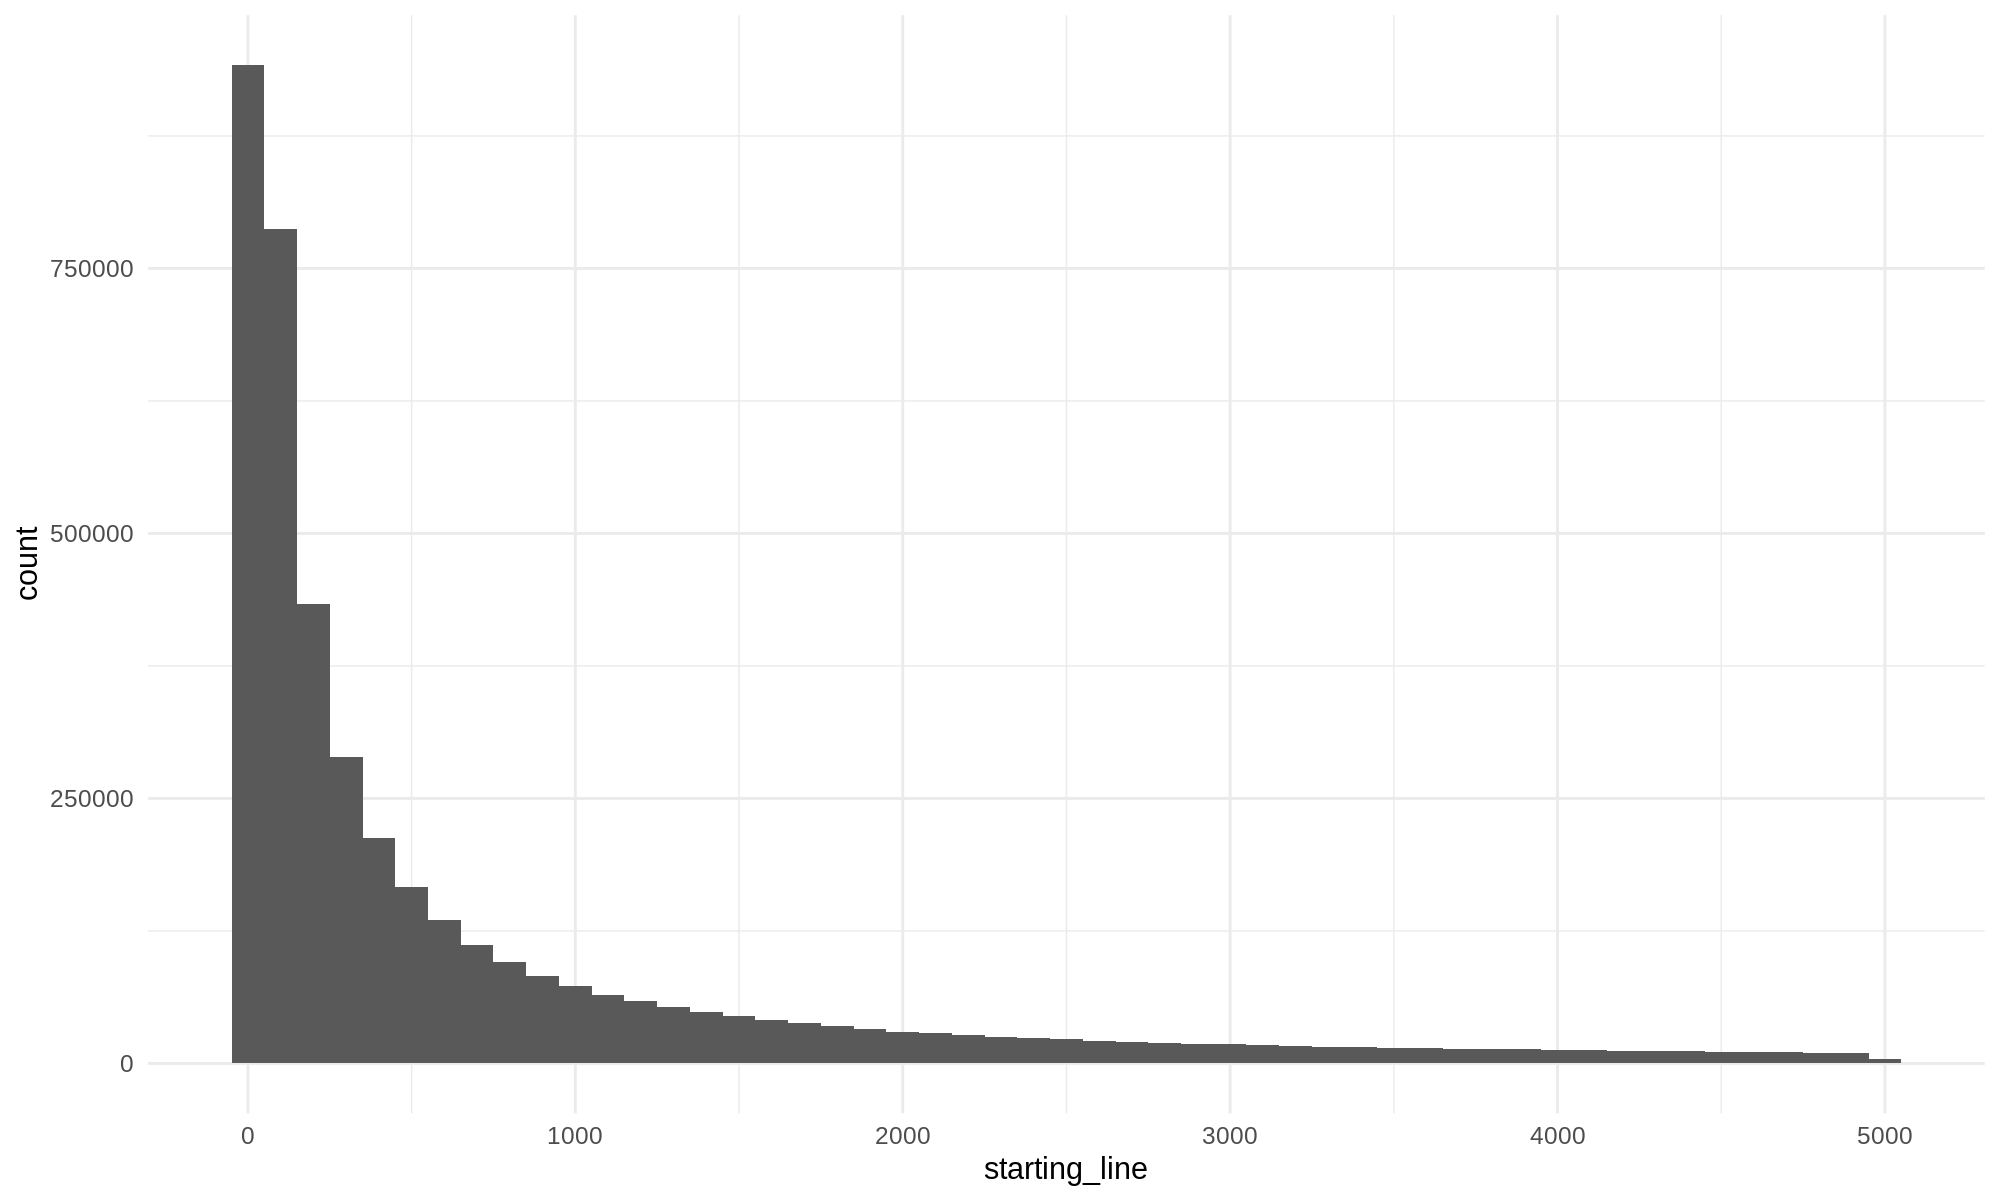

In [6]:
#here we take a look at starting line number.
#the logarthmic distribution is to be expected because a large line number snippet cannot exist without a corresponding lower
#numbered snippet, however the inverse is not true. So, there can be more small line number snippets.

startingLines <- codeSnippets %>%
    #remove starting lines above 5000
    mutate(starting_line = if_else(
        (starting_line < 5000),
        starting_line,
        NA %>% as.double()
    )) %>% 
    drop_na(starting_line) %>%

    ggplot(aes(
        x = starting_line,
        #y = (..count..) / sum(..count..)
    )) +
    geom_histogram(
        binwidth = 100
    ) +
    theme_minimal() +
    labs()

startingLines